In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv004.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import skimage
import matplotlib.pyplot as plt
nax = np.newaxis

sys.path.append('..')
%aimport mre_pinn

Using backend: pytorch



# BIOQIC Phantom ground truth

In [136]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', 'phantom', baseline=True, downsample=False)
data

Loading ../data/BIOQIC/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64
Multi frequency 3D
<xarray.Dataset>
Dimensions:    (frequency: 8, component: 3, z: 25, x: 128, y: 80)
Coordinates:
  * frequency  (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component  (component) <U1 'z' 'y' 'x'
  * z          (z) float64 0.0 0.0015 0.003 0.0045 ... 0.0315 0.033 0.0345 0.036
  * x          (x) float64 0.0 0.0015 0.003 0.0045 ... 0.186 0.1875 0.189 0.1905
  * y          (y) float64 0.0 0.0015 0.003 0.0045 ... 0.114 0.1155 0.117 0.1185
Data variables:
    u          (frequency, x, y, z, component) comple

<xarray.Dataset>
Dimensions:    (frequency: 8, component: 3, z: 25, x: 128, y: 80)
Coordinates:
  * frequency  (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component  (component) <U1 'z' 'y' 'x'
  * z          (z) float64 0.0 0.0015 0.003 0.0045 ... 0.0315 0.033 0.0345 0.036
  * x          (x) float64 0.0 0.0015 0.003 0.0045 ... 0.186 0.1875 0.189 0.1905
  * y          (y) float64 0.0 0.0015 0.003 0.0045 ... 0.114 0.1155 0.117 0.1185
Data variables:
    u          (frequency, x, y, z, component) complex128 (0.0052072014338709...
    Lu         (frequency, x, y, z, component) complex128 (24455.052534709666...
    Mu         (frequency, x, y, z) complex128 (-11.746959791257547-0.4028714...

<IPython.core.display.Javascript object>


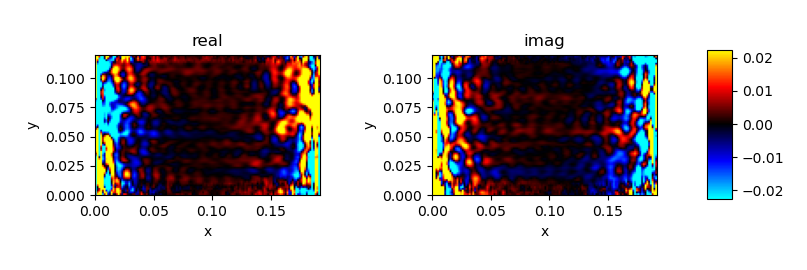

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


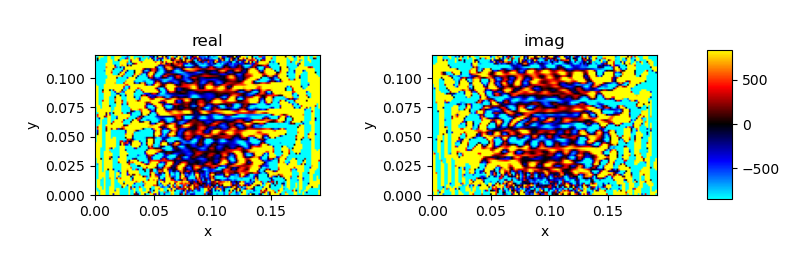

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


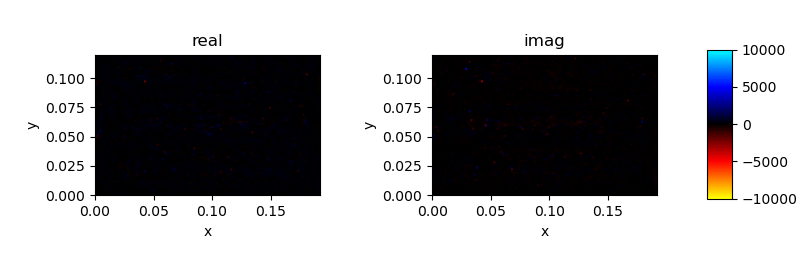

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [137]:
%autoreload

wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu, pct=50)
elast_kws = mre_pinn.visual.get_color_kws(data.Mu, pct=50)

mre_pinn.visual.XArrayViewer(data.u,  col='part', **wave_kws)
mre_pinn.visual.XArrayViewer(data.Lu, col='part', **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu, col='part', **elast_kws)

In [33]:
phase_shift = (data.u.median(dim=['t', 'x', 'y', 'z']) / (2 * np.pi)).round() * (2 * np.pi)

phase_shift

<xarray.DataArray 'u' (frequency: 8, component: 3)>
array([[-0.        , -0.        ,  0.        ],
       [-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [ 6.28318531, -0.        ,  0.        ],
       [ 6.28318531,  6.28318531,  6.28318531],
       [-0.        , -0.        ,  0.        ],
       [12.56637061, -0.        ,  0.        ],
       [-0.        , -0.        ,  0.        ]])
Coordinates:
  * frequency  (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component  (component) <U1 'z' 'y' 'x'

In [82]:
data.u.shape

(8, 128, 80, 25, 3)

In [90]:
import scipy


array([[[1.58261808e-07, 5.49644784e-06, 1.79489926e-05, 5.49644784e-06,
         1.58261808e-07],
        [5.49644784e-06, 1.90892163e-04, 6.23370240e-04, 1.90892163e-04,
         5.49644784e-06],
        [1.79489926e-05, 6.23370240e-04, 2.03565432e-03, 6.23370240e-04,
         1.79489926e-05],
        [5.49644784e-06, 1.90892163e-04, 6.23370240e-04, 1.90892163e-04,
         5.49644784e-06],
        [1.58261808e-07, 5.49644784e-06, 1.79489926e-05, 5.49644784e-06,
         1.58261808e-07]],

       [[5.49644784e-06, 1.90892163e-04, 6.23370240e-04, 1.90892163e-04,
         5.49644784e-06],
        [1.90892163e-04, 6.62970319e-03, 2.16497085e-02, 6.62970319e-03,
         1.90892163e-04],
        [6.23370240e-04, 2.16497085e-02, 7.06984706e-02, 2.16497085e-02,
         6.23370240e-04],
        [1.90892163e-04, 6.62970319e-03, 2.16497085e-02, 6.62970319e-03,
         1.90892163e-04],
        [5.49644784e-06, 1.90892163e-04, 6.23370240e-04, 1.90892163e-04,
         5.49644784e-06]],

      